In [46]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [47]:
def current_time():
    time = datetime.now()
    return time.strftime("%H:%M:%S")

In [48]:
# Bands from 10m
band3_10m = 'data_10m/bands/T42TXK_20200913T060641_B03_10m.jp2'
band8_10m = 'data_10m/bands/T42TXK_20200913T060641_B08_10m.jp2'

# Bands from 20m
band3_20m = 'data_20m/bands/T42TXK_20200913T060641_B03_20m.jp2'
band4_20m = 'data_20m/bands/T42TXK_20200913T060641_B04_20m.jp2'
band8_20m = 'data_20m/bands/T42TXK_20200913T060641_B8A_20m.jp2'
band11_20m = 'data_20m/bands/T42TXK_20200913T060641_B11_20m.jp2'
band12_20m = 'data_20m/bands/T42TXK_20200913T060641_B12_20m.jp2'

In [49]:
# Opening bands with gdal
    # Bands 10m
band3_10m = gdal.Open(band3_10m)
band8_10m = gdal.Open(band8_10m)
    # Bands 20m
band3_20m = gdal.Open(band3_20m)
band4_20m = gdal.Open(band4_20m)
band8_20m = gdal.Open(band8_20m)
band11_20m = gdal.Open(band11_20m)
band12_20m = gdal.Open(band12_20m)

In [50]:
# Reading bands
    # Bands 10m
print('Reading start 10m bands:', current_time())
green_10m = band3_10m.ReadAsArray(buf_type=gdal.GDT_Float32)
nir_10m = band8_10m.ReadAsArray(buf_type=gdal.GDT_Float32)
print('Reading end 10m bands:', current_time())
    # Bands 20m
print()
print('Reading start 20m bands:', current_time())
green_20m = band3_20m.ReadAsArray(buf_type=gdal.GDT_Float32)
red_20m = band4_20m.ReadAsArray(buf_type=gdal.GDT_Float32)
nir_20m = band8_20m.ReadAsArray(buf_type=gdal.GDT_Float32)
swir11_20m = band11_20m.ReadAsArray(buf_type=gdal.GDT_Float32)
swir12_20m = band12_20m.ReadAsArray(buf_type=gdal.GDT_Float32)
print('Reading end 20m bands:', current_time())

Reading start 10m bands: 17:27:03
Reading end 10m bands: 17:27:14

Reading start 20m bands: 17:27:14
Reading end 20m bands: 17:27:22


In [51]:
# Create calculating function
def cal_water_ind(green, nir=None, red=None, swir11=None, swir12=None, key='ndwi'):
    if key == 'ndwi':
        ndwi = np.where(green + nir == 0., 0.,
                       (green - nir) / (green + nir))
        return ndwi
    
    elif key == 'mndwi':
        mndwi = np.where(green + swir12 == 0., 0.,
                        (green - swir12) / (green + swir12))
        return mndwi
    
    elif key == 'awei':
        awei = np.where(0.25 * nir + 2.75 * swir11 == 0., 0.,
                       4 * (green - swir12) / (0.25 * nir + 2.75 * swir11))
        return awei
    
    elif key == 'wri':
        wri = np.where(nir + swir12 == 0., 0.,
                      (green + red) / (nir + swir12))
        return wri

# Create ploting functions
def plot_once(data, title, cmp=None):
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    ax.imshow(data, cmap=cmp)
    ax.axis('off')
    ax.set_title(title)

def plot_multi(datas, titles, cmps=None):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    for i, ax in enumerate(axes):
        ax[0].imshow(datas[i][0], cmap=cmps[i][0])
        ax[0].axis('off')
        ax[0].set_title(titles[i][0])
        
        ax[1].imshow(datas[i][1], cmap=cmps[i][1])
        ax[1].axis('off')
        ax[1].set_title(titles[i][1])

In [52]:
# calculate water indexes
print('Calculating start:', current_time())
ndwi = cal_water_ind(green=green_10m, nir=nir_10m)
mndwi = cal_water_ind(green=green_20m, swir12=swir12_20m, key='mndwi')
awei = cal_water_ind(green=green_20m, nir=nir_20m, swir11=swir11_20m, swir12=swir12_20m, key='awei')
wri = cal_water_ind(green=green_20m, nir=nir_20m, red=red_20m, swir12=swir12_20m, key='wri')
print('Calculating end:', current_time())

Calculating start: 17:27:22
Calculating end: 17:27:25


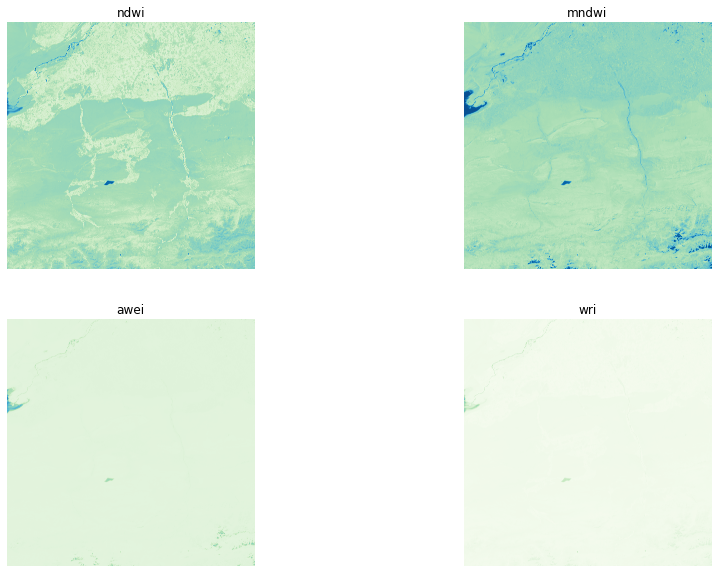

In [53]:
datas = [[ndwi, mndwi], [awei, wri]]
titles = [['ndwi', 'mndwi'], ['awei', 'wri']]
cmps = [['GnBu', 'GnBu'], ['GnBu', 'GnBu']]
plot_multi(datas=datas, titles=titles, cmps=cmps)

In [58]:
# Create saving function
def save_raster(set_data, cr_data, outpath):
    rasterset = gdal.GetDriverByName('GTiff').Create(
        outpath, cr_data.RasterXSize, cr_data.RasterYSize,
        1, gdal.GDT_Float32)
    rasterset.SetProjection(cr_data.GetProjection())
    rasterset.SetGeoTransform(cr_data.GetGeoTransform())
    rasterset.GetRasterBand(1).WriteArray(set_data)
    rasterset.GetRasterBand(1).SetNoDataValue(-999)
    rasterset = None

In [59]:
ndwi_outpath = 'data_20m/layers/NDWI_10m.tiff'         # band3_10m
mndwi_outpath = 'data_20m/layers/MNDWI_20m.tiff'       # band3_20m
awei_outpath = 'data_20m/layers/AWEI_20m.tiff'         # band3_20m
wri_outpath = 'data_20m/layers/WRI_20m.tiff'           # band4_20m

In [60]:
print('Saving start:', current_time())
save_raster(set_data=ndwi, cr_data=band3_10m, outpath=ndwi_outpath)
save_raster(set_data=mndwi, cr_data=band3_20m, outpath=mndwi_outpath)
save_raster(set_data=awei, cr_data=band3_20m, outpath=awei_outpath)
save_raster(set_data=wri, cr_data=band4_20m, outpath=wri_outpath)
print('Saving end:', current_time())

Saving start: 17:30:08
Saving end: 17:30:10
